In [ ]:
# You will need the following imports for this assessment. You can make additional imports when you need them

import keras
from keras import ops
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.models import Sequential
from keras.layers import Input, Dense

#### CASIA-Webface Dataset

This notebook makes use of the CASIA-Webface dataset, which is used for face verification and face identification tasks. The complete dataset consists of 494,414 face images of 10,575 real identities collected from the web. In this notebook, a smaller subset of the dataset has been prepared.

The dataset was first introduced in the following paper:

*  Yi, D., Lei, Z., Liao, S. and Li, S.Z. (2014), "Learning Face Representation from Scratch", arXiv preprint, abs/1411.7923.

The data subset is available in the folder `./data/casia-webface`.

#### Contrastive learning

I will develop a deep learning model that can be used to verify if two images belong to the same person or not. The model will take an image as input, and output a fixed size embedding. The model will be trained such that different images belonging to the same identity should have embeddings that are close to each other (in some sense), and images belonging to different identities should have embeddings that are far apart.

The training algorithm I will use for this will be a form of contrastive learning. This is a learning paradigm where the objective function compares different examples in the dataset.

In particular, to train the model I will use a loss function that takes three examples: an anchor input $\mathbf{x}$, a positive example $\mathbf{x}^+$ that is similar to the anchor (the same identity), and a negative example $\mathbf{x}^-$ that is different to the anchor. The objective for the network is to embed the images such that the similarity between the anchor and positive example is maximised (or distance is minimised), and the similarity between the anchor and negative example is minimised (distance is maximised).

<center><img src="figures/contrastive-learning.png" alt="Similarity of representations" style="width: 450px;"/></center>
<center>The model's objective is to minimize the distance (in embedding space) between an anchor and a positive example, both of which have the same identity, and maximize the distance between the anchor and a negative example of a different identity</center>
<br>

The loss function I will use is the circle loss, given by:

$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma (\alpha_n(s_n - \Delta_n) - \alpha_p(s_p - \Delta_p))\right],
$$
where $s_p$ (resp. $s_n$) is the positive (resp. negative) similarity score computed between the anchor and positive (resp. anchor and negative) examples, according to some choice of similarity measure in the embedding space. The hyperparameters $\alpha_p>0$ and $\alpha_n>0$ are example-specific weightings to emphasise either the positive or negative similarity scores in the gradient updates, and $\Delta_p>0$ and $\Delta_n>0$ are the positive and negative margins. 

The circle loss was introduced in the following paper:

* Sun, Y., Cheng, C., Zhang, Y., Zhang, C., Zheng, L. and Wang, Z. (2020), "Circle Loss: A Unified Perspective of Pair Similarity Optimization," *IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), Seattle, WA, USA*, 6397-6406.

Basic exploration and analysis of the dataset.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

zip_path = "/content/drive/My Drive/MSc/ICL - 23/DL/data.zip"
!unzip -q "$zip_path" -d "/content/data"

Mounted at /content/drive


In [ ]:
import random
from pathlib import Path
from PIL import Image

# Define dataset path
dataset_path = Path("/content/data/data/casia-webface")

# Initialise variables
identity_image_counts = {}
image_paths = []
image_shapes = []
pixel_min_values = []
pixel_max_values = []
image_types = []

# Traverse dataset
for identity_folder in dataset_path.iterdir():
    if identity_folder.is_dir():
        # Get all files in the folder
        images = list(identity_folder.glob("*"))
        # Store identity-wise image counts
        identity_image_counts[identity_folder.name] = len(images)
        image_paths.extend(images)
        # Process images for shape analysis and pixel value range
        for image_path in images:
            with Image.open(image_path) as img:
                # Convert image to numpy array
                img_array = np.array(img)
                # Store shape (height, width, channels)
                image_shapes.append(img_array.shape)
                # Store min and max pixel values
                pixel_min_values.append(img_array.min())
                pixel_max_values.append(img_array.max())
                # Store file type
                image_types.append(img.format)

# Compute and display key CASIA-Webface dataset statistics
num_identities = len(identity_image_counts)
num_images = len(image_paths)
images_per_identity = list(identity_image_counts.values())
print("CASIA-Webface dataset statistics")
print(f"\nNumber of images: {num_images}")
print(f"Number of identities: {num_identities}")
print(f"Maximum images per identity: {max(images_per_identity)}")
print(f"Minimum images per identity: {min(images_per_identity)}")
print(f"Median images per identity: {np.median(images_per_identity):.1f}")

# Check if all images have the same shape
if len(set(image_shapes)) == 1:
    print(f"All images have shape: {image_shapes[0]}")
else:
    print("Images have varying shapes.")

# Check if all images have the same file type
if len(set(image_types)) == 1:
    print(f"All images are of type: .{image_types[0].lower()}")
else:
    print("Images have varying file formats.")

# Check pixel value range
print(f"Pixel value range: {min(pixel_min_values)} to {max(pixel_max_values)}")

CASIA-Webface dataset statistics

Number of images: 211958
Number of identities: 8000
Maximum images per identity: 50
Minimum images per identity: 10
Median images per identity: 23.0
All images have shape: (112, 112, 3)
All images are of type: .jpeg
Pixel value range: 0 to 255


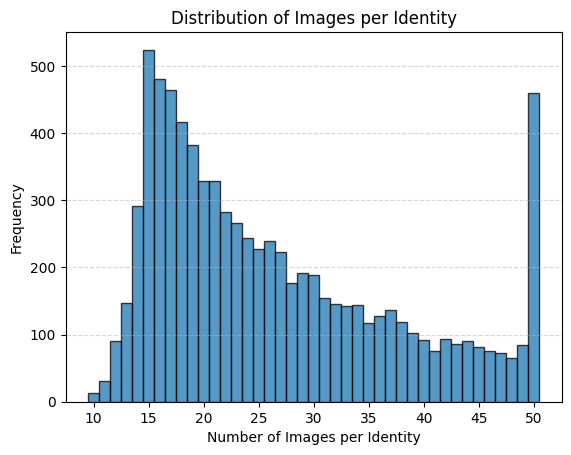

In [ ]:
# Plot distribution of images per identity
plt.figure()
bin_edges = np.arange(min(images_per_identity) - 0.5, max(images_per_identity) + 1.5, 1)
plt.hist(images_per_identity, bins=bin_edges, edgecolor='black', alpha=0.75)
plt.xlabel("Number of Images per Identity")
plt.ylabel("Frequency")
plt.title("Distribution of Images per Identity")
plt.xticks(np.arange(min(images_per_identity), max(images_per_identity) + 1, step=5))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

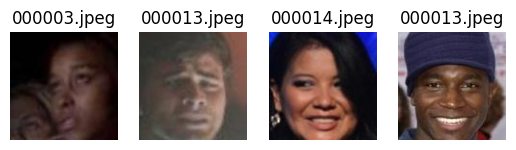

In [ ]:
# Visualise random sample images
def visualise_random_images(image_paths, num_samples=4):
    sample_images = random.sample(image_paths, min(num_samples, len(image_paths)))
    plt.figure()
    for i, image_path in enumerate(sample_images):
        img = Image.open(image_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(image_path))
        plt.axis('off')
    plt.show()

visualise_random_images(image_paths)

Create the dataset object(s) that will be used to train and evaluate the model.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Sampler
import torchvision.transforms as transforms
from collections import defaultdict

# Set key hyperparameters
num_identities = 1000
min_images_per_identity = 10
max_images_per_identity = 20
batch_size = 32
images_per_identity = 4  # Number of images per identity per batch

# Image transformations (normalisation for model input)
image_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert from [0, 255] to [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalise to [-1,1]
])

# Define dataset class for CASIA-WebFace
class casia_webface_dataset(Dataset):
    def __init__(self, root_dir, num_identities, min_images_per_identity, max_images_per_identity, transform=None):
        """
        Creates a dataset of face images with identities.
        Args:
        - root_dir (Path): Path to dataset folder.
        - num_identities (int): Number of identities to select.
        - min_images_per_identity (int): Minimum images per identity.
        - max_images_per_identity (int): Maximum images per identity.
        - transform: Transformation applied to images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []  # List of image tensors
        self.identities = []  # List of identity labels

        # Get all identity directories
        all_identities = sorted([identity for identity in self.root_dir.iterdir() if identity.is_dir()])
        # Randomly select a subset of identities
        selected_identities = random.sample(all_identities, min(num_identities, len(all_identities)))
        # Assign each identity a unique numerical label
        self.identity_to_index = {identity.name: idx for idx, identity in enumerate(selected_identities)}
        # Collect and process image paths
        for identity in selected_identities:
            image_paths = list(identity.iterdir())
            if len(image_paths) >= min_images_per_identity:
                selected_images = random.sample(image_paths, min(random.randint(min_images_per_identity, max_images_per_identity), len(image_paths)))
                for image_path in selected_images:
                    image = Image.open(image_path).convert("RGB")
                    if self.transform:
                        image = self.transform(image)  # Shape: (C, H, W)
                        image = image.permute(1, 2, 0)  # Convert to (H, W, C)
                    self.images.append(image)  # Store tensor image
                    self.identities.append(self.identity_to_index[identity.name])  # Store identity
        # Convert lists to tensors
        self.images = torch.stack(self.images)  # Shape: (N, H, W, C)
        self.identities = torch.tensor(self.identities, dtype=torch.long)  # Shape: (N,)

    def __len__(self):
        """Returns the total number of images in the dataset."""
        return len(self.images)

    def __getitem__(self, index):
        """Returns an identity and corresponding image (in the correct order)."""
        return self.identities[index], self.images[index]  # Swapped order

# Define custom batch sampler to ensure each batch contains multiple images from the same identity
class contrastive_batch_sampler(Sampler):
    def __init__(self, dataset, batch_size, images_per_identity):
        self.dataset = dataset
        self.batch_size = batch_size
        self.images_per_identity = images_per_identity
        self.identity_to_indices = defaultdict(list)
        # Group image indices by identity
        for idx, (identity, _) in enumerate(dataset):  # Updated tuple unpacking
            self.identity_to_indices[identity.item()].append(idx)
        # Filter identities with enough images
        self.valid_identities = [identity for identity, indices in self.identity_to_indices.items() if len(indices) >= images_per_identity]
        print(f"Found {len(self.valid_identities)} valid identities with at least {images_per_identity} images each.")
        self.batch_count = None  # Store actual batch count after `__iter__` runs

    def __iter__(self):
        """Generates batches where each batch contains multiple identities."""
        batch_count = 0
        used_identities = set()
        while True:
            available_identities = list(set(self.valid_identities) - used_identities)
            if len(available_identities) < (self.batch_size // self.images_per_identity):
                break
            selected_identities = random.sample(available_identities, self.batch_size // self.images_per_identity)
            batch = []
            for identity in selected_identities:
                indices = random.sample(self.identity_to_indices[identity], self.images_per_identity)
                batch.extend(indices)
                used_identities.add(identity)
            yield batch
            batch_count += 1
        self.batch_count = batch_count

    def __len__(self):
        """Returns the actual number of batches per epoch, based on the last run of `__iter__`."""
        return self.batch_count if self.batch_count is not None else len(self.valid_identities) // (self.batch_size // self.images_per_identity)

# Create dataset and dataloader
dataset = casia_webface_dataset(dataset_path, num_identities, min_images_per_identity, max_images_per_identity, image_transform)
batch_sampler = contrastive_batch_sampler(dataset, batch_size, images_per_identity)
dataloader = DataLoader(dataset, batch_sampler=batch_sampler, num_workers=2)

Found 1000 valid identities with at least 4 images each.


In [ ]:
print("Dataset verification")
num_identities = len(set(dataset.identities.tolist()))
num_images = len(dataset)
print(f"\nNumber of images: {num_images}")
print(f"Number of identities: {num_identities}")
print(f"(Expected: {min_images_per_identity} - {max_images_per_identity} images per identity)")
print(f"identities tensor shape: {dataset.identities.shape} (Expected: ({num_images},))")
print(f"images tensor shape: {dataset.images.shape} (Expected: ({num_images}, 112, 112, 3))")

print("\nDataLoader verification")
identities, images = next(iter(dataloader))
print(f"\nidentities tensor shape (batch): {identities.shape} (Expected: ({batch_size},))")
print(f"images tensor shape (batch): {images.shape} (Expected: ({batch_size},112, 112, 3))")
unique_identities = identities.unique().tolist()
print(f"Unique identities in batch: {len(unique_identities)} (Expected max: {batch_size // images_per_identity})")

Dataset verification

Number of images: 14527
Number of identities: 1000
(Expected: 10 - 20 images per identity)
identities tensor shape: torch.Size([14527]) (Expected: (14527,))
images tensor shape: torch.Size([14527, 112, 112, 3]) (Expected: (14527, 112, 112, 3))

DataLoader verification

identities tensor shape (batch): torch.Size([32]) (Expected: (32,))
images tensor shape (batch): torch.Size([32, 112, 112, 3]) (Expected: (32,112, 112, 3))
Unique identities in batch: 8 (Expected max: 8)


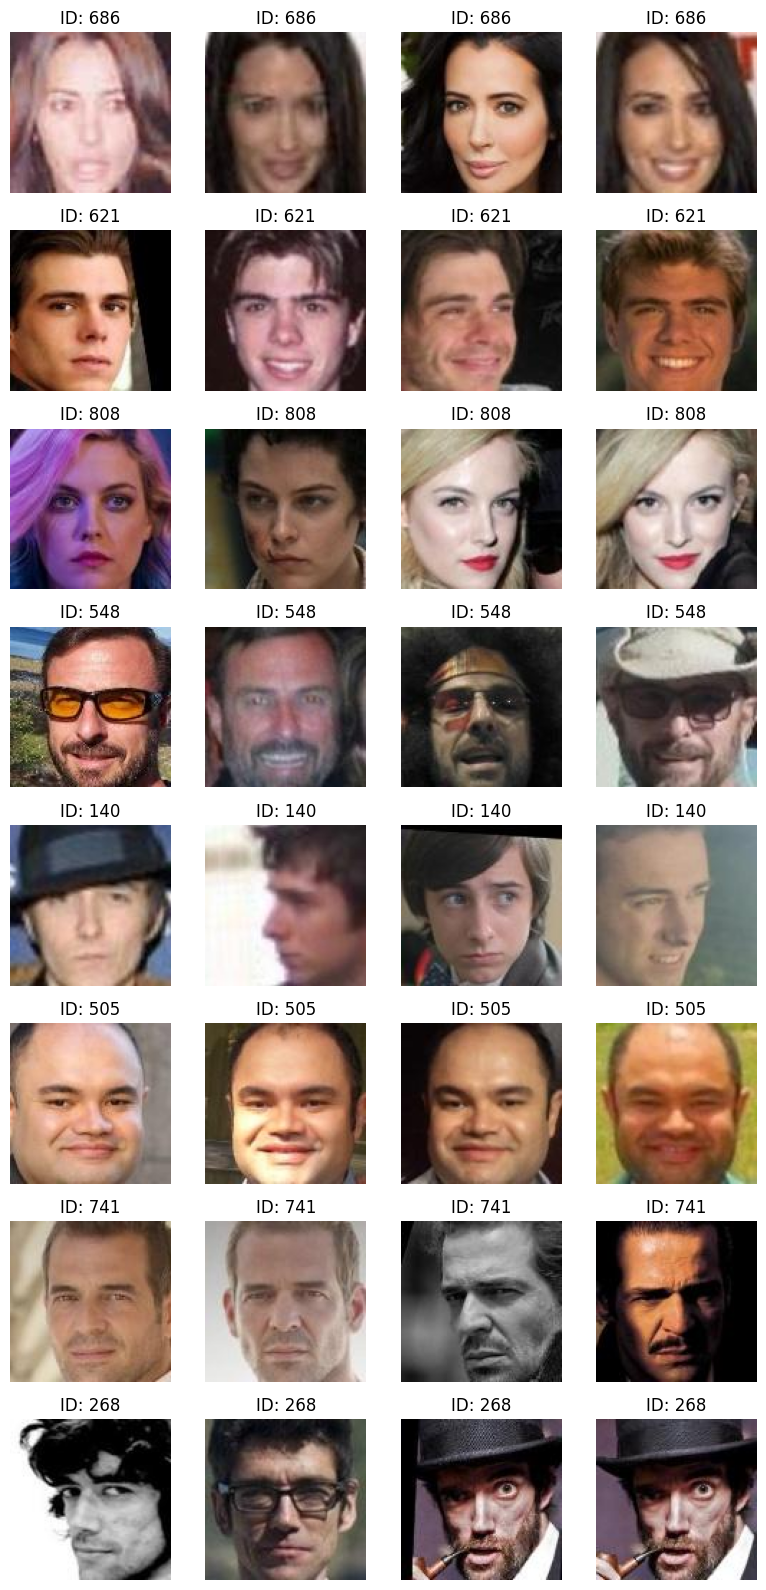

In [ ]:
# Visualise a batch of images from the dataloader
def visualise_batch(dataloader):
    """Displays images from a random batch, arranged in rows of 4."""
    # Get a random batch
    identities, images = next(iter(dataloader))
    batch_size = images.shape[0]
    # Denormalise images (convert back to [0, 1] for display)
    mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 1, 1, 3) # Adjusted shape for (N, H, W, C)
    std = torch.tensor([0.5, 0.5, 0.5]).view(1, 1, 1, 3)
    images = images * std + mean
    # Convert to numpy and clip values to [0, 1]
    images = images.numpy().clip(0, 1)
    # Plot
    num_cols = 4
    num_rows = (batch_size + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    for i in range(batch_size):
        row, col = divmod(i, num_cols)
        axes[row, col].imshow(images[i])
        axes[row, col].set_title(f"ID: {identities[i].item()}")
        axes[row, col].axis("off")
    # Hide unused axes if batch size is not a multiple of 4
    for i in range(batch_size, num_rows * num_cols):
        row, col = divmod(i, num_cols)
        axes[row, col].axis("off")
    plt.tight_layout()
    plt.show()

# Display images from a random batch
visualise_batch(dataloader)

Recall the circle loss is given by

$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma (\alpha_n(s_n - \Delta_n) - \alpha_p(s_p - \Delta_p))\right],\tag{1}
$$

where $\alpha_p>0$, $\alpha_n>0$, $\Delta_p>0$ and $\Delta_n>0$ are hyperparameters, and $s_p$ and $s_n$ are the similarity scores between anchor-positive and anchor-negative pairs according to some similarity measure.

The [triplet loss](https://en.wikipedia.org/wiki/Triplet_loss) is a similar loss function for contrastive learning that was developed a few years earlier. It is given by:

$$
\mathcal{L}_{\textrm{triplet}}(\mathbf{x}, \mathbf{x}^+, \mathbf{x}^-) =  \max(0, || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+) ||_2^2 - || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-) ||_2^2  + m)\tag{2}
$$

where $f_\theta$ is a network that maps images to a fixed-size embedding, $\mathbf{x}$ is an anchor example, $\mathbf{x}^+$ is a corresponding positive example, and $\mathbf{x}^-$ is a negative example, and $m>0$ is a hyperparameter that sets the minimum offset between distances of similar vs dissimilar pairs. 

I will now show that the triplet loss can be derived from the circle loss as a certain limit, with a certain choice of hyperparameters $\alpha_p$, $\alpha_n$, $\Delta_p$ and $\Delta_n$ and similarity measure.

Choose the negative squared Euclidean distance as the similarity measure:

$$
s(\mathbf{x}, \mathbf{x}') = -|| f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}') ||_2^2.
$$

Then

$$
s_p = -|| f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+) ||_2^2, \quad s_n = -|| f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-) ||_2^2
$$

and

$$
\mathcal{L}_{\textrm{circle}} = \frac{1}{\gamma} \log \left[ 1 + \exp \big( \gamma (\alpha_n (-|| f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-) ||_2^2 - \Delta_n) - \alpha_p (-|| f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+) ||_2^2 - \Delta_p) ) \big) \right]
$$

$$
\implies \mathcal{L}_{\textrm{circle}} = \frac{1}{\gamma} \log \left[ 1 + \exp \big( \gamma ( -\alpha_n || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-) ||_2^2 - \alpha_n \Delta_n + \alpha_p || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+) ||_2^2 + \alpha_p \Delta_p ) \big) \right]
$$

$$
\implies \mathcal{L}_{\textrm{circle}} = \frac{1}{\gamma} \log \left[ 1 + \exp \big( \gamma ( \alpha_p || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+) ||_2^2 -\alpha_n || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-) ||_2^2 + \alpha_p \Delta_p - \alpha_n \Delta_n ) \big) \right].
$$

As $ x \to \infty $,

$$
1 + \exp(x) \approx \exp(x)
$$

$$
\implies \log(1 + \exp(x)) \approx x.
$$

As $ x \to -\infty $,

$$
1 + \exp(x) \approx 1
$$

$$
\implies \log(1 + \exp(x)) \approx 0.
$$

Therefore,

$$
\log(1 + \exp(x)) \approx \max(0, x)
$$

as $|x| \to \infty$.

So in the limit $ \gamma \to \infty $,

$$
\mathcal{L}_{\textrm{circle}} \approx \max(0, \alpha_p || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+) ||_2^2 -\alpha_n || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-) ||_2^2 + \alpha_p \Delta_p - \alpha_n \Delta_n).
$$

Comparing this with the triplet loss

$$
\mathcal{L}_{\textrm{triplet}} = \max(0, || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+) ||_2^2 - || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-) ||_2^2 + m),
$$

we see that triplet loss can be obtained by choosing:

$$
\alpha_p = \alpha_n = 1, \quad \Delta_p = 2 m, \quad \Delta_n = m.
$$

I will use the circle loss to train the model. Following Sun et al., I will assume that the similarity score takes values between 0 and 1. A suitable choice of similarity measure that satisfies this is the scaled cosine similarity $s(\mathbf{x}_1, \mathbf{x}_2) = (\langle \mathbf{x}_1, \mathbf{x}_2 \rangle + 1) / 2$, where $\mathbf{x}_1$ and $\mathbf{x}_2$ have been normalised such that $||\mathbf{x}_1||_2 = ||\mathbf{x}_2||_2 = 1$.

With this choice, typical settings for the hyperparameters in the circle loss are

$$
\begin{align}
\alpha_p &= 1 + m - s_p\\
\alpha_n &= s_n + m\\
\Delta_p &= 1 - m\\
\Delta_n &= m
\end{align}
$$

where $0<m<1$ is the _margin_. These settings reduce the hyperparameters in the loss function to just one (the margin $m$).

In [ ]:
import tensorflow as tf

def circle_loss(anchor_embeddings, positive_embeddings, negative_embeddings, m=0.2, gamma=64):
    """
    Computes the circle loss.
    Parameters:
        anchor_embeddings (tf.Tensor): Tensor of shape (N, d) for anchor embeddings.
        positive_embeddings (tf.Tensor): Tensor of shape (N, d) for positive embeddings.
        negative_embeddings (tf.Tensor): Tensor of shape (N, d) for negative embeddings.
        m (float): Margin between 0 and 1.
        gamma (float): Positive scaling factor.
    Returns:
        tf.Tensor: The computed circle loss.
    """
    # Compute cosine similarity
    s_p = (tf.reduce_sum(anchor_embeddings * positive_embeddings, axis=1) + 1) / 2
    s_n = (tf.reduce_sum(anchor_embeddings * negative_embeddings, axis=1) + 1) / 2
    # Compute alpha_p, alpha_n, Delta_p and Delta_n
    alpha_p = 1 + m - s_p
    alpha_n = s_n + m
    delta_p = 1 - m
    delta_n = m
    # Compute circle loss
    loss = (1 / gamma) * tf.math.log(1 + tf.exp(gamma * (alpha_n * (s_n - delta_n) - alpha_p * (s_p - delta_p))))
    return tf.reduce_mean(loss)

In [ ]:
# Test Circle Loss Function

# Generate random l2-normalised embeddings (batch size = 32, embedding dimension = 128)
batch_size = 32
embedding_dim = 128
anchor_embeddings = tf.nn.l2_normalize(tf.random.normal((batch_size, embedding_dim)), axis=1)
positive_embeddings = tf.nn.l2_normalize(tf.random.normal((batch_size, embedding_dim)), axis=1)
negative_embeddings = tf.nn.l2_normalize(tf.random.normal((batch_size, embedding_dim)), axis=1)

# Compute and display circle loss
loss = circle_loss(anchor_embeddings, positive_embeddings, negative_embeddings, m=0.2, gamma=64)
print(f"Circle Loss Value: {loss.numpy():.4f}")

Circle Loss Value: 0.4262


Implement a model that will be trained on the face verification task, using the circle loss defined above.

In [ ]:
from keras import layers
import keras.backend as K
from keras.layers import Conv2D, MaxPooling2D, Flatten, Lambda
from keras.saving import register_keras_serializable

# l2-normalisation function
@register_keras_serializable()
def l2_norm_layer(x):
    return x / (tf.norm(x, axis=1, keepdims=True) + K.epsilon())

# Simple Sequential model
def build_optimized_embedding_model(input_shape=(112, 112, 3), embedding_dim=128):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(512, activation="relu"),
        Dense(embedding_dim, activation="linear"),

        Lambda(l2_norm_layer, name="l2_norm")
    ])

    return model

# Build and print the model summary to show details of chosen design
optimized_model = build_optimized_embedding_model()
optimized_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 112, 112, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ l2_norm (Lambda)                     │ (None, 128)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,004,480 (49.61 MB)

 Trainable params: 13,004,480 (49.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def get_triplets(batch_identities, batch_images, model, selection_strategy="hardest"):
    """
    Selects triplets (anchor, positive, negative) based on the specified strategy.
    Parameters:
        batch_identities (numpy.ndarray or tf.Tensor): Identity labels, shape (N,).
        batch_images (numpy.ndarray or tf.Tensor): Batch of images, shape (N, 112, 112, 3).
        model (tf.keras.Model): The embedding model.
        selection_strategy (str): 'hardest' selects the most challenging triplets,
                                  'random' selects triplets randomly.
    Returns:
        List of tuples (anchor_index, positive_index, negative_index).
    """
    # Ensure batch_identities and batch_images are numpy arrays
    if isinstance(batch_identities, tf.Tensor):
        batch_identities = batch_identities.numpy()
    if isinstance(batch_images, tf.Tensor):
        batch_images = batch_images.numpy()
    # Compute embeddings using the model (without training updates)
    batch_embeddings = model(batch_images, training=False)
    # Compute cosine similarity between all pairs of embeddings
    similarity_matrix = tf.matmul(batch_embeddings, batch_embeddings, transpose_b=True)
    # Convert similarity into a distance measure (1 - similarity)
    distance_matrix = 1 - similarity_matrix

    batch_size = batch_embeddings.shape[0]
    selected_triplets = []
    # Get unique identities present in the batch
    unique_identities = np.unique(batch_identities)

    for identity in unique_identities:
        # Get all indices where the identity matches (potential anchors and positives)
        identity_indices = np.where(batch_identities == identity)[0]
        # Skip if no valid anchor samples
        if len(identity_indices) == 0:
            continue
        # Select an anchor from this identity (always pick the first occurrence)
        anchor_index = identity_indices[0]
        # Get indices for positive and negative samples
        # Positives exclude the anchor
        positive_indices = identity_indices[identity_indices != anchor_index]
        # Negatives are different identities
        negative_indices = np.where(batch_identities != identity)[0]
        # Skip if not enough samples to form a triplet
        if len(positive_indices) == 0 or len(negative_indices) == 0:
            continue

        if selection_strategy == "hardest":
            # Select the hardest positive (furthest within-class sample)
            hardest_positive = positive_indices[np.argmax(distance_matrix.numpy()[anchor_index, positive_indices])]
            # Select the hardest negative (closest out-of-class sample)
            hardest_negative = negative_indices[np.argmin(distance_matrix.numpy()[anchor_index, negative_indices])]
            selected_triplets.append((anchor_index, hardest_positive, hardest_negative))

        elif selection_strategy == "random":
            # Randomly select a positive sample
            random_positive = np.random.choice(positive_indices)
            # Randomly select a negative sample
            random_negative = np.random.choice(negative_indices)
            selected_triplets.append((anchor_index, random_positive, random_negative))

    return selected_triplets

In [ ]:
# Get a random batch
batch_identities, batch_images = next(iter(dataloader))
# Convert batch to numpy
batch_identities_np = batch_identities.numpy()
batch_images_np = batch_images.numpy()
# Get triplets using hardest selection
triplets = get_triplets(batch_identities_np, batch_images_np, optimized_model, selection_strategy="hardest")
# Display 5 of the triplets selected
print("5 of the triplets selected\n")
for i, (anchor, positive, negative) in enumerate(triplets[:5]):
    print(f"Triplet {i+1}: anchor_index={anchor}, positive_index={positive}, negative_index={negative}")

5 of the triplets selected

Triplet 1: anchor_index=4, positive_index=5, negative_index=0
Triplet 2: anchor_index=16, positive_index=17, negative_index=8
Triplet 3: anchor_index=12, positive_index=15, negative_index=30
Triplet 4: anchor_index=28, positive_index=31, negative_index=1
Triplet 5: anchor_index=20, positive_index=23, negative_index=24


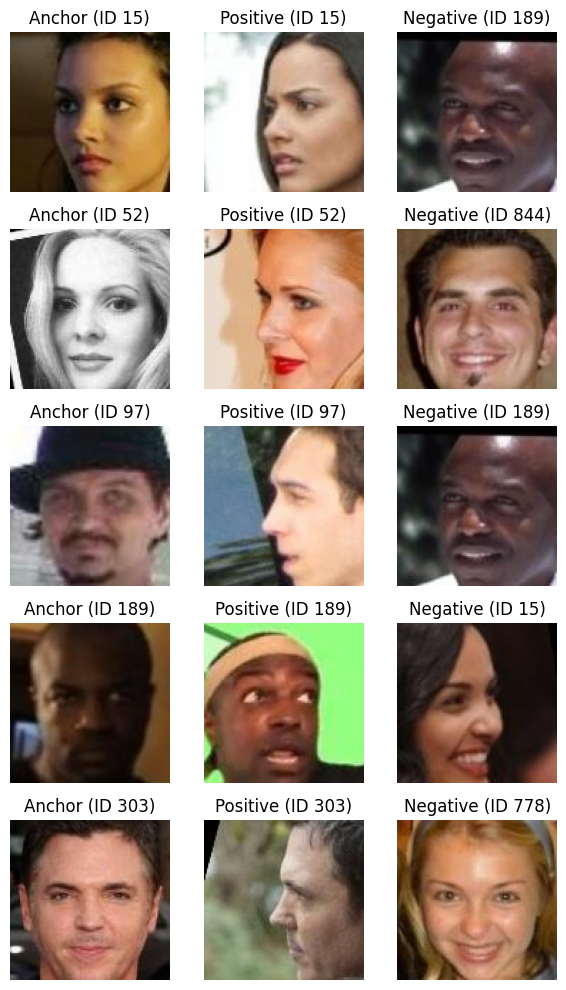

In [ ]:
# Visualise 5 of the triplets selected from a random batch
def visualise_triplets(dataloader, model, selection_strategy="hardest"):
    """
    Displays 5 images from a random batch as triplets (anchor, positive, negative).
    Each row represents one triplet.
    """
    # Get a random batch
    identities, images = next(iter(dataloader))
    # Convert batch to numpy
    batch_identities_np = identities.numpy()
    batch_images_np = images.numpy()
    # Get triplets using hardest selection
    triplets = get_triplets(batch_identities_np, batch_images_np, model, selection_strategy)
    if len(triplets) == 0:
        print("No valid triplets found in this batch.")
        return
    # Denormalise images (convert back to [0, 1] for display)
    mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 1, 1, 3)
    std = torch.tensor([0.5, 0.5, 0.5]).view(1, 1, 1, 3)
    images = images * std + mean
    # Convert to numpy and clip values to [0, 1]
    images = images.numpy().clip(0, 1)
    # Display 5 of the triplets selected
    num_triplets = min(len(triplets), 5)
    # Plot
    fig, axes = plt.subplots(num_triplets, 3, figsize=(6, 2 * num_triplets))
    for i, (anchor_idx, positive_idx, negative_idx) in enumerate(triplets[:num_triplets]):
        axes[i, 0].imshow(images[anchor_idx])
        axes[i, 0].set_title(f"Anchor (ID {batch_identities_np[anchor_idx]})")
        axes[i, 0].axis("off")
        axes[i, 1].imshow(images[positive_idx])
        axes[i, 1].set_title(f"Positive (ID {batch_identities_np[positive_idx]})")
        axes[i, 1].axis("off")
        axes[i, 2].imshow(images[negative_idx])
        axes[i, 2].set_title(f"Negative (ID {batch_identities_np[negative_idx]})")
        axes[i, 2].axis("off")
    plt.tight_layout()
    plt.show()

# Display 5 of the triplets selected from a random batch
visualise_triplets(dataloader, optimized_model, selection_strategy="hardest")

Write and execute a custom training loop to train the model.

In [ ]:
import time
from tqdm import tqdm
from torch.utils.data import random_split

# Set key hyperparameters
epochs = 20
# Define Adam optimiser
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# Create DataLoaders with batch sampler for both training and validation
train_dataloader = DataLoader(
    train_dataset,
    batch_sampler=contrastive_batch_sampler(train_dataset, batch_size, images_per_identity),
    num_workers=2
)
val_dataloader = DataLoader(
    val_dataset,
    batch_sampler=contrastive_batch_sampler(val_dataset, batch_size, images_per_identity),
    num_workers=2
)
# Custom training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    # Start time for epoch tracking
    start_time = time.time()
    # Reset DataLoader iterator for new epoch
    dataloader_iter = iter(train_dataloader)
    # Training phase
    batch_idx = 0
    total_loss = 0.0
    with tqdm(total=len(train_dataloader), desc="Training", unit="batch") as pbar:
        while True:
            try:
                # Retrieve next batch of identities and images
                batch_identities, batch_images = next(dataloader_iter)
            except StopIteration:
                break
            batch_idx += 1
            # Convert pytorch tensors to numpy arrays
            batch_identities_np = batch_identities.numpy()
            batch_images_np = batch_images.numpy()
            # Select triplets using hardest negative mining for training
            triplets = get_triplets(batch_identities_np, batch_images_np, optimized_model, selection_strategy="hardest")
            # Skip batch if no valid triplets found
            if len(triplets) == 0:
                pbar.update(1)
                continue
            # Extract triplet indices
            anchor_idxs, positive_idxs, negative_idxs = zip(*triplets)
            # Convert selected triplets to tensorflow tensors
            anchor_images = tf.convert_to_tensor(batch_images_np[list(anchor_idxs)])
            positive_images = tf.convert_to_tensor(batch_images_np[list(positive_idxs)])
            negative_images = tf.convert_to_tensor(batch_images_np[list(negative_idxs)])
            # Compute gradients and update model weights
            with tf.GradientTape() as tape:
                anchor_embeddings = optimized_model(anchor_images, training=True)
                positive_embeddings = optimized_model(positive_images, training=True)
                negative_embeddings = optimized_model(negative_images, training=True)
                loss = circle_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
            gradients = tape.gradient(loss, optimized_model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, optimized_model.trainable_variables))
            # Accumulate total loss
            total_loss += loss.numpy()
            # Update progress bar with current batch loss
            pbar.set_postfix(current_loss=f"{loss.numpy():.4f}")
            pbar.update(1)
    # Compute the average training loss for the epoch
    avg_train_loss = total_loss / batch_idx
    # Calculate epoch duration
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time:.1f}s - Average training loss: {avg_train_loss:.4f}")
    # Validation phase
    total_val_loss = 0.0
    batch_idx = 0
    with tqdm(total=len(val_dataloader), desc="Validating", unit="batch") as pbar:
        for batch_identities, batch_images in val_dataloader:
            batch_idx += 1
            # Convert pytorch tensors to numpy arrays
            batch_identities_np = batch_identities.numpy()
            batch_images_np = batch_images.numpy()
            # Select triplets using random selection for validation
            triplets = get_triplets(batch_identities_np, batch_images_np, optimized_model, selection_strategy="random")
            # Skip batch if no valid triplets found
            if len(triplets) == 0:
                pbar.update(1)
                continue
            # Extract triplet indices
            anchor_idxs, positive_idxs, negative_idxs = zip(*triplets)
            # Convert selected triplets to tensorflow tensors
            anchor_images = tf.convert_to_tensor(batch_images_np[list(anchor_idxs)])
            positive_images = tf.convert_to_tensor(batch_images_np[list(positive_idxs)])
            negative_images = tf.convert_to_tensor(batch_images_np[list(negative_idxs)])
            # Compute validation loss without updating model weights
            anchor_embeddings = optimized_model(anchor_images, training=False)
            positive_embeddings = optimized_model(positive_images, training=False)
            negative_embeddings = optimized_model(negative_images, training=False)
            val_loss = circle_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
            # Accumulate total validation loss
            total_val_loss += val_loss.numpy()
            # Update progress bar with current batch validation loss
            pbar.set_postfix(current_loss=f"{val_loss.numpy():.4f}")
            pbar.update(1)
    # Compute the average validation loss for the epoch
    avg_val_loss = total_val_loss / max(batch_idx, 1)
    print(f"Average validation loss after epoch {epoch + 1}: {avg_val_loss:.4f}")
    # Save the model at the end of each epoch
    model_path = f"/content/optimized_model_epoch_{epoch+1:02d}.keras"
    optimized_model.save(model_path)
    print(f"Model saved successfully: {model_path}")

Found 1000 valid identities with at least 4 images each.
Found 326 valid identities with at least 4 images each.

Epoch 1/20


Training: 100%|██████████| 125/125 [03:23<00:00,  1.63s/batch, current_loss=0.6820]


Epoch 1 completed in 203.4s - Average training loss: 0.7250


Validating: 100%|██████████| 40/40 [00:23<00:00,  1.67batch/s, current_loss=0.4487]


Average validation loss after epoch 1: 0.4184
Model saved successfully: /content/optimized_model_epoch_01.keras

Epoch 2/20


Training: 100%|██████████| 125/125 [03:09<00:00,  1.52s/batch, current_loss=0.6556]


Epoch 2 completed in 190.1s - Average training loss: 0.6735


Validating: 100%|██████████| 40/40 [00:30<00:00,  1.30batch/s, current_loss=0.4523]


Average validation loss after epoch 2: 0.4329
Model saved successfully: /content/optimized_model_epoch_02.keras

Epoch 3/20


Training: 100%|██████████| 125/125 [03:07<00:00,  1.50s/batch, current_loss=0.6785]


Epoch 3 completed in 187.9s - Average training loss: 0.6535


Validating: 100%|██████████| 40/40 [00:24<00:00,  1.66batch/s, current_loss=0.4164]


Average validation loss after epoch 3: 0.4098
Model saved successfully: /content/optimized_model_epoch_03.keras

Epoch 4/20


Training: 100%|██████████| 125/125 [03:06<00:00,  1.49s/batch, current_loss=0.6192]


Epoch 4 completed in 186.7s - Average training loss: 0.6367


Validating: 100%|██████████| 40/40 [00:25<00:00,  1.56batch/s, current_loss=0.4040]


Average validation loss after epoch 4: 0.4219
Model saved successfully: /content/optimized_model_epoch_04.keras

Epoch 5/20


Training: 100%|██████████| 125/125 [03:08<00:00,  1.51s/batch, current_loss=0.6529]


Epoch 5 completed in 189.0s - Average training loss: 0.6232


Validating: 100%|██████████| 40/40 [00:29<00:00,  1.36batch/s, current_loss=0.3864]


Average validation loss after epoch 5: 0.4043
Model saved successfully: /content/optimized_model_epoch_05.keras

Epoch 6/20


Training: 100%|██████████| 125/125 [03:15<00:00,  1.56s/batch, current_loss=0.6380]


Epoch 6 completed in 195.9s - Average training loss: 0.6148


Validating: 100%|██████████| 40/40 [00:25<00:00,  1.57batch/s, current_loss=0.4391]


Average validation loss after epoch 6: 0.4118
Model saved successfully: /content/optimized_model_epoch_06.keras

Epoch 7/20


Training: 100%|██████████| 125/125 [03:10<00:00,  1.52s/batch, current_loss=0.6691]


Epoch 7 completed in 190.3s - Average training loss: 0.6120


Validating: 100%|██████████| 40/40 [00:24<00:00,  1.61batch/s, current_loss=0.4315]


Average validation loss after epoch 7: 0.4010
Model saved successfully: /content/optimized_model_epoch_07.keras

Epoch 8/20


Training: 100%|██████████| 125/125 [03:07<00:00,  1.50s/batch, current_loss=0.6180]


Epoch 8 completed in 187.6s - Average training loss: 0.6003


Validating: 100%|██████████| 40/40 [00:30<00:00,  1.31batch/s, current_loss=0.4096]


Average validation loss after epoch 8: 0.3904
Model saved successfully: /content/optimized_model_epoch_08.keras

Epoch 9/20


Training: 100%|██████████| 125/125 [03:08<00:00,  1.51s/batch, current_loss=0.5665]


Epoch 9 completed in 188.6s - Average training loss: 0.5915


Validating: 100%|██████████| 40/40 [00:27<00:00,  1.47batch/s, current_loss=0.3512]


Average validation loss after epoch 9: 0.3761
Model saved successfully: /content/optimized_model_epoch_09.keras

Epoch 10/20


Training: 100%|██████████| 125/125 [03:14<00:00,  1.56s/batch, current_loss=0.5223]


Epoch 10 completed in 194.8s - Average training loss: 0.5849


Validating: 100%|██████████| 40/40 [00:25<00:00,  1.54batch/s, current_loss=0.4056]


Average validation loss after epoch 10: 0.3826
Model saved successfully: /content/optimized_model_epoch_10.keras

Epoch 11/20


Training: 100%|██████████| 125/125 [03:08<00:00,  1.51s/batch, current_loss=0.5697]


Epoch 11 completed in 188.5s - Average training loss: 0.5821


Validating: 100%|██████████| 40/40 [00:30<00:00,  1.29batch/s, current_loss=0.3959]


Average validation loss after epoch 11: 0.3982
Model saved successfully: /content/optimized_model_epoch_11.keras

Epoch 12/20


Training: 100%|██████████| 125/125 [03:09<00:00,  1.51s/batch, current_loss=0.5626]


Epoch 12 completed in 189.7s - Average training loss: 0.5810


Validating: 100%|██████████| 40/40 [00:24<00:00,  1.65batch/s, current_loss=0.4156]


Average validation loss after epoch 12: 0.3916
Model saved successfully: /content/optimized_model_epoch_12.keras

Epoch 13/20


Training: 100%|██████████| 125/125 [03:08<00:00,  1.51s/batch, current_loss=0.5593]


Epoch 13 completed in 188.6s - Average training loss: 0.5744


Validating: 100%|██████████| 40/40 [00:26<00:00,  1.53batch/s, current_loss=0.3558]

Average validation loss after epoch 13: 0.3821
Model saved successfully: /content/optimized_model_epoch_13.keras

Epoch 14/20



Training: 100%|██████████| 125/125 [03:09<00:00,  1.52s/batch, current_loss=0.5224]


Epoch 14 completed in 189.9s - Average training loss: 0.5672


Validating: 100%|██████████| 40/40 [00:25<00:00,  1.55batch/s, current_loss=0.3359]


Average validation loss after epoch 14: 0.3752
Model saved successfully: /content/optimized_model_epoch_14.keras

Epoch 15/20


Training: 100%|██████████| 125/125 [03:15<00:00,  1.56s/batch, current_loss=0.5312]


Epoch 15 completed in 195.7s - Average training loss: 0.5609


Validating: 100%|██████████| 40/40 [00:27<00:00,  1.48batch/s, current_loss=0.4036]


Average validation loss after epoch 15: 0.3771
Model saved successfully: /content/optimized_model_epoch_15.keras

Epoch 16/20


Training: 100%|██████████| 125/125 [03:08<00:00,  1.51s/batch, current_loss=0.5292]


Epoch 16 completed in 188.3s - Average training loss: 0.5583


Validating: 100%|██████████| 40/40 [00:30<00:00,  1.31batch/s, current_loss=0.3664]


Average validation loss after epoch 16: 0.3879
Model saved successfully: /content/optimized_model_epoch_16.keras

Epoch 17/20


Training: 100%|██████████| 125/125 [03:09<00:00,  1.51s/batch, current_loss=0.5587]


Epoch 17 completed in 189.6s - Average training loss: 0.5575


Validating: 100%|██████████| 40/40 [00:25<00:00,  1.55batch/s, current_loss=0.3734]


Average validation loss after epoch 17: 0.3763
Model saved successfully: /content/optimized_model_epoch_17.keras

Epoch 18/20


Training: 100%|██████████| 125/125 [03:13<00:00,  1.55s/batch, current_loss=0.5476]


Epoch 18 completed in 193.9s - Average training loss: 0.5581


Validating: 100%|██████████| 40/40 [00:25<00:00,  1.57batch/s, current_loss=0.4298]


Average validation loss after epoch 18: 0.3841
Model saved successfully: /content/optimized_model_epoch_18.keras

Epoch 19/20


Training: 100%|██████████| 125/125 [03:10<00:00,  1.52s/batch, current_loss=0.5898]


Epoch 19 completed in 190.7s - Average training loss: 0.5502


Validating: 100%|██████████| 40/40 [00:29<00:00,  1.36batch/s, current_loss=0.3987]


Average validation loss after epoch 19: 0.3807
Model saved successfully: /content/optimized_model_epoch_19.keras

Epoch 20/20


Training: 100%|██████████| 125/125 [03:09<00:00,  1.52s/batch, current_loss=0.5251]


Epoch 20 completed in 190.1s - Average training loss: 0.5451


Validating: 100%|██████████| 40/40 [00:24<00:00,  1.64batch/s, current_loss=0.4581]


Average validation loss after epoch 20: 0.3774
Model saved successfully: /content/optimized_model_epoch_20.keras


I will view the trained model as a binary classifier that predicts whether two images are the same person or not. I will test the trained model on a subset of the Labeled Faces in the Wild (LFW) dataset. This dataset also consists of a number of identities, and a number of images per identity. It was introduced in the following paper:

* Huang, G.B., Ramesh, M., Berg, T., and Learned-Miller, E. (2007), "Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments", University of Massachusetts, Amherst, Technical Report 07-49.

The subset is available in the folder `./data/labeled-faces-in-the-wild`.  There is also the file `lfw_test_pairs.txt` in the `./data` folder that I will use for testing. This file lists a number of pairs of images in the LFW dataset that either belong to the same identity or different identities.

I will now use the best model from above to compute predictions on the LFW subset to say whether or not two images are the same person.

In [ ]:
# Define dataset paths
lfw_path = "/content/data/data/labeled-faces-in-the-wild"
pairs_file = "/content/data/data/lfw_test_pairs.txt"

# Initialise variables
same_count = 0
diff_count = 0
test_pairs = []
image_shapes = []
image_types = []
total_images = 0
pixel_min_values = []
pixel_max_values = []

# Read test pairs file
with open(pairs_file, "r") as f:
    lines = f.readlines()
    for line in lines:
        parts = line.strip().split()
        img1_path, img2_path = None, None

        # Same identity pair
        if len(parts) == 3:
            person, img1, img2 = parts
            img1_path = os.path.join(lfw_path, person, f"{person}_{str(img1).zfill(4)}.jpg")
            img2_path = os.path.join(lfw_path, person, f"{person}_{str(img2).zfill(4)}.jpg")
            same_count += 1

        # Different identity pair
        elif len(parts) == 4:
            person1, img1, person2, img2 = parts
            img1_path = os.path.join(lfw_path, person1, f"{person1}_{str(img1).zfill(4)}.jpg")
            img2_path = os.path.join(lfw_path, person2, f"{person2}_{str(img2).zfill(4)}.jpg")
            diff_count += 1

        # Append only valid image pairs
        if img1_path and img2_path and os.path.exists(img1_path) and os.path.exists(img2_path):
            test_pairs.append((img1_path, img2_path))
            total_images += 2

            # Check image properties
            for img_path in (img1_path, img2_path):
                img = Image.open(img_path)
                image_shapes.append(img.size)
                image_types.append(img.format)

                # Convert image to numpy array to check pixel value range
                img_array = np.array(img)
                pixel_min_values.append(img_array.min())
                pixel_max_values.append(img_array.max())

# Compute and print dataset statistics
print("LFW Dataset Statistics")
print(f"\nTotal number of images: {total_images}")
print(f"Total same identity pairs: {same_count}")
print(f"Total different identity pairs: {diff_count}")

# Ensure all images have the same file type and size
if len(set(image_shapes)) == 1:
    print(f"All images have shape: {image_shapes[0]}")
else:
    print("Images have varying shapes.")

if len(set(image_types)) == 1:
    print(f"All images are of type: .{image_types[0].lower()}")
else:
    print("Images have varying file formats.")

# Check pixel value range
print(f"Pixel value range: {min(pixel_min_values)} to {max(pixel_max_values)}")

LFW Dataset Statistics

Total number of images: 12000
Total same identity pairs: 3000
Total different identity pairs: 3000
All images have shape: (250, 250)
All images are of type: .jpeg
Pixel value range: 0 to 255


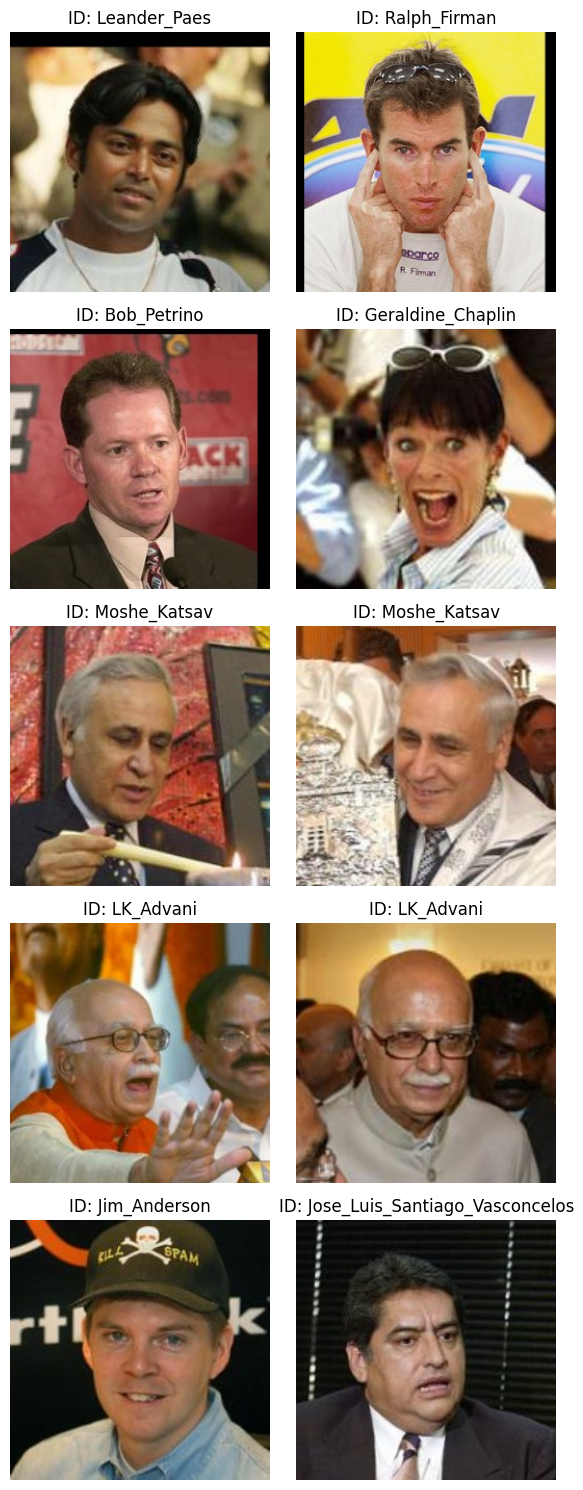

In [ ]:
# Visualise five random pairs of images with identity labels
def visualise_random_pairs(test_pairs, num_pairs=5):
    """Displays random image pairs with identity names above each image."""
    num_cols = 2
    num_rows = num_pairs
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    for i in range(num_pairs):
        # Select a random pair
        img1_path, img2_path = random.choice(test_pairs)
        identity1 = os.path.basename(os.path.dirname(img1_path))
        identity2 = os.path.basename(os.path.dirname(img2_path))
        # Load images
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        # Plot first image
        axes[i, 0].imshow(img1)
        axes[i, 0].set_title(f"ID: {identity1}")
        axes[i, 0].axis("off")
        # Plot second image
        axes[i, 1].imshow(img2)
        axes[i, 1].set_title(f"ID: {identity2}")
        axes[i, 1].axis("off")
    plt.tight_layout()
    plt.show()

# Display five random image pairs
visualise_random_pairs(test_pairs)

In [ ]:
from keras.preprocessing import image

# Load saved model
model_path = "/content/optimized_model_epoch_9.keras"
try:
    loaded_model = tf.keras.models.load_model(model_path, custom_objects={"l2_norm_layer": l2_norm_layer})
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Image preprocessing
def preprocess_image(img_path, target_size=(112, 112)):
    """
    Loads and preprocesses an image for the face embedding model.
    Ensures resizing to (112,112) and normalisation to match training data.
    """
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) # Shape (H, W, C), values in [0, 255]
    img_array = img_array / 255.0 # Normalise to [0, 1]
    img_array = (img_array - 0.5) / 0.5 # Normalise to [-1, 1]
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    return img_array

# Compute model embeddings for test pairs
same_scores = []
diff_scores = []
# Read test pairs
with open(pairs_file, "r") as f:
    lines = f.readlines()[1:] # Skip first line
total_pairs = len(lines)
start_time = time.time()
for i, line in enumerate(lines):
    parts = line.strip().split()
    img1_path, img2_path = None, None
    # Same person
    if len(parts) == 3:
        person, img1, img2 = parts
        img1_path = os.path.join(lfw_path, person, f"{person}_{str(img1).zfill(4)}.jpg")
        img2_path = os.path.join(lfw_path, person, f"{person}_{str(img2).zfill(4)}.jpg")
    # Different people
    elif len(parts) == 4:
        person1, img1, person2, img2 = parts
        img1_path = os.path.join(lfw_path, person1, f"{person1}_{str(img1).zfill(4)}.jpg")
        img2_path = os.path.join(lfw_path, person2, f"{person2}_{str(img2).zfill(4)}.jpg")
    if img1_path and img2_path and os.path.exists(img1_path) and os.path.exists(img2_path):
        # Preprocess images
        img1 = preprocess_image(img1_path, target_size=(112, 112))
        img2 = preprocess_image(img2_path, target_size=(112, 112))
        # Compute embeddings
        emb1 = loaded_model.predict(img1, verbose=0)
        emb2 = loaded_model.predict(img2, verbose=0)
        # Compute cosine similarity
        similarity = (np.dot(emb1, emb2.T) + 1) / 2  # Normalise to [0, 1]
        # Store in corresponding list
        if len(parts) == 3:
            same_scores.append(similarity[0, 0])
        elif len(parts) == 4:
            diff_scores.append(similarity[0, 0])
    # Progress updates
    if (i + 1) % 100 == 0 or i + 1 == total_pairs:
        elapsed_time = time.time() - start_time
        avg_time_per_pair = elapsed_time / (i + 1)
        estimated_time_left = avg_time_per_pair * (total_pairs - (i + 1))
        print(f"Processed {i+1}/{total_pairs} pairs ({(i+1)/total_pairs*100:.2f}%) - "
              f"Elapsed: {elapsed_time:.2f}s, Estimated time left: {estimated_time_left:.2f}s")

print(f"\nFinished processing {len(same_scores)} same-identity pairs and {len(diff_scores)} different-identity pairs")
print(f"Mean similarity (same identity): {np.mean(same_scores):.4f}")
print(f"Mean similarity (different identity): {np.mean(diff_scores):.4f}")

Model loaded successfully
Processed 100/6000 pairs (1.67%) - Elapsed: 26.84s, Estimated time left: 1583.69s
Processed 200/6000 pairs (3.33%) - Elapsed: 49.47s, Estimated time left: 1434.75s
Processed 300/6000 pairs (5.00%) - Elapsed: 73.80s, Estimated time left: 1402.18s
Processed 400/6000 pairs (6.67%) - Elapsed: 97.99s, Estimated time left: 1371.80s
Processed 500/6000 pairs (8.33%) - Elapsed: 120.05s, Estimated time left: 1320.60s
Processed 600/6000 pairs (10.00%) - Elapsed: 143.15s, Estimated time left: 1288.33s
Processed 700/6000 pairs (11.67%) - Elapsed: 166.29s, Estimated time left: 1259.02s
Processed 800/6000 pairs (13.33%) - Elapsed: 188.45s, Estimated time left: 1224.89s
Processed 900/6000 pairs (15.00%) - Elapsed: 211.58s, Estimated time left: 1198.98s
Processed 1000/6000 pairs (16.67%) - Elapsed: 235.99s, Estimated time left: 1179.97s
Processed 1100/6000 pairs (18.33%) - Elapsed: 259.27s, Estimated time left: 1154.93s
Processed 1200/6000 pairs (20.00%) - Elapsed: 281.58s, Es

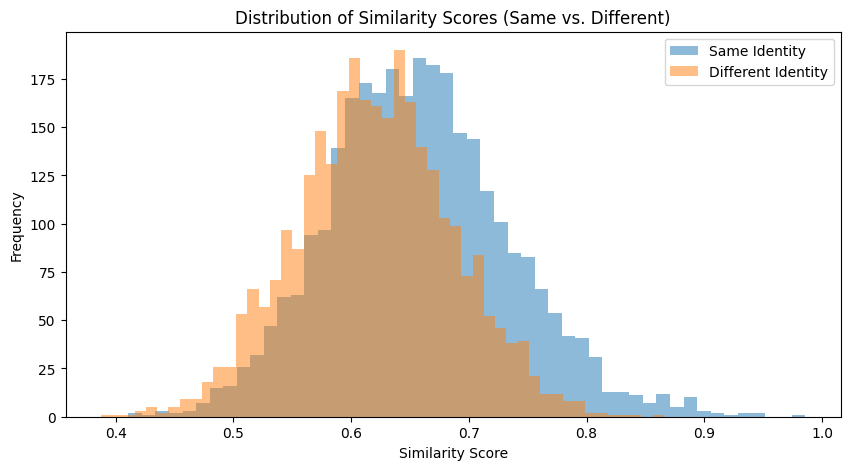

In [ ]:
# Display histogram with the distribution of positive and negative similarity scores from model
plt.figure(figsize=(10, 5))
plt.hist(same_scores, bins=50, alpha=0.5, label="Same Identity")
plt.hist(diff_scores, bins=50, alpha=0.5, label="Different Identity")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores (Same vs. Different)")
plt.legend()
plt.show()

Use the computed similarity scores from above to calculate the area under the ROC curve and the area under the precision-recall (PR) curve for the classifier model.

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve

# Convert similarity scores to ground-truth labels (1 for same, 0 for different)
true_labels = np.concatenate([
    np.ones(len(same_scores)), # Label 1 for same identity
    np.zeros(len(diff_scores)) # Label 0 for different identity
])
predicted_scores = np.concatenate([same_scores, diff_scores])  # Combine similarity scores
# Compute ROC and PR curves
fpr, tpr, roc_thresholds = roc_curve(true_labels, predicted_scores)
precision, recall, pr_thresholds = precision_recall_curve(true_labels, predicted_scores)
# Compute AUC for both curves using Keras AUC metric
auc_roc = tf.keras.metrics.AUC()(tf.convert_to_tensor(true_labels), tf.convert_to_tensor(predicted_scores)).numpy()
auc_pr = tf.keras.metrics.AUC(curve="PR")(tf.convert_to_tensor(true_labels), tf.convert_to_tensor(predicted_scores)).numpy()
# Display AUC values
print(f"AUC (ROC curve): {auc_roc:.4f}")
print(f"AUC (PR curve): {auc_pr:.4f}")

AUC (ROC curve): 0.6407
AUC (PR curve): 0.6549


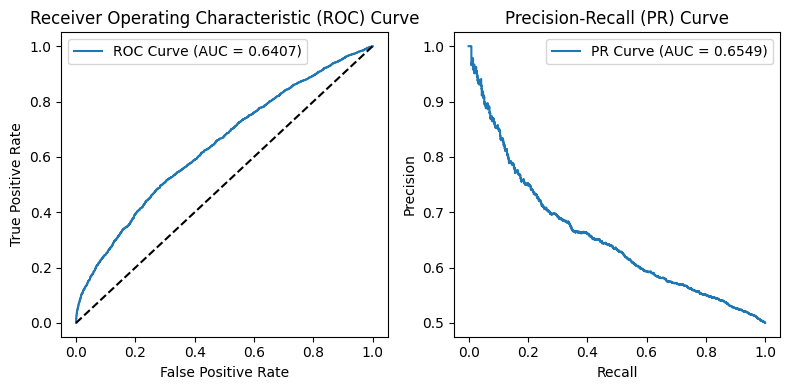

In [ ]:
# Display ROC and PR curves
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_roc:.4f})")
plt.plot([0, 1], [0, 1], "k--")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"PR Curve (AUC = {auc_pr:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall (PR) Curve")
plt.legend()
plt.tight_layout()
plt.show()

Compute the threshold that maximises the accuracy of the classifier on the LFW test data. Plot the accuracy as a function of the threshold, and report the optimal threshold and resulting accuracy.

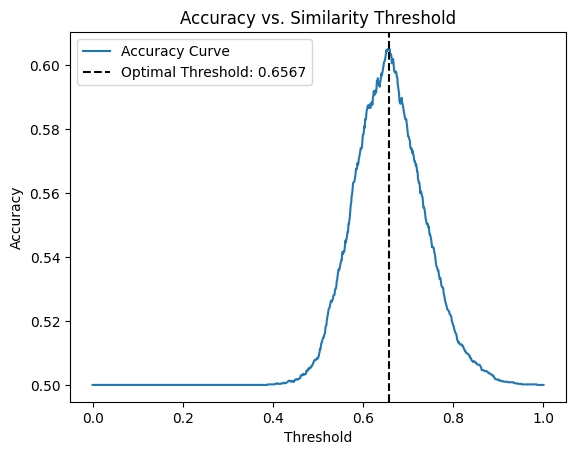

In [ ]:
# Compute the threshold that maximises the accuracy of the classifier on the LFW test data
def find_optimal_threshold(same_scores, diff_scores):
    """Compute the threshold that maximises the accuracy of the classifier on the LFW test data."""
    thresholds = np.linspace(0, 1, 1000)
    best_threshold = 0
    best_accuracy = 0
    accuracies = []
    for threshold in thresholds:
        # Predict labels using threshold
        same_preds = np.array(same_scores) >= threshold # True for same identity
        diff_preds = np.array(diff_scores) < threshold # True for different identity
        # Compute accuracy
        correct_same = np.sum(same_preds)
        correct_diff = np.sum(diff_preds)
        total = len(same_scores) + len(diff_scores)
        accuracy = (correct_same + correct_diff) / total
        accuracies.append(accuracy)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    return best_threshold, best_accuracy, thresholds, accuracies

# Compute optimal threshold and resulting accuracy
optimal_threshold, max_accuracy, thresholds, accuracies = find_optimal_threshold(same_scores, diff_scores)

# Plot accuracy vs. threshold
plt.figure()
plt.plot(thresholds, accuracies, label="Accuracy Curve")
plt.axvline(optimal_threshold, color="black", linestyle="--", label=f"Optimal Threshold: {optimal_threshold:.4f}")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Similarity Threshold")
plt.legend()
plt.show()

In [ ]:
# Report optimal threshold and resulting accuracy
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Resulting accuracy: {max_accuracy:.4f}")

Optimal threshold: 0.6567
Resulting accuracy: 0.6052
